# Imports and API configuration

In [1]:
import praw
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from datetime import datetime, timezone, timedelta
import os, datetime as dt
import re
import operator

In [2]:
with open("../redditCredentials.json", "r") as f:
    credentials = json.load(f)

In [3]:
reddit = praw.Reddit(client_id=credentials['CLIENT_ID'],
                     client_secret=credentials['SECRET_TOKEN'],
                     password=credentials['PASSWORD'],
                     user_agent='AITA-analysis',
                     username=credentials['USERNAME'],
                     check_for_async=False)

# Data Collection and Preprocessing

## Gathering top submissions

### A-HOLE

In [9]:
submissions_data = []
limit = 250
query = 'flair:"Asshole"' 
subreddit = reddit.subreddit("AmItheAsshole")

accepted = 0 

for submission in subreddit.search(query, sort="top", time_filter="all", limit=None):

    flair = (submission.link_flair_text or '').lower().strip()
    if not flair.startswith('asshole'):  
        continue

    accepted += 1
    if accepted > limit:
        break

    if accepted % 30 == 0:
        print(f"{accepted}/{limit} iterations")

    submission_data = {
        'author': getattr(submission, 'author', None),
        'author_flair_text': getattr(submission, 'author_flair_text', None),
        'clicked': submission.clicked,
        'comments': submission.comments,
        'created_utc': submission.created_utc,
        'created_time': datetime.fromtimestamp(submission.created_utc),
        'distinguished': submission.distinguished,
        'edited': submission.edited,
        'id': submission.id,
        'is_original_content': submission.is_original_content,
        'is_self': submission.is_self,
        'link_flair_template_id': getattr(submission, 'link_flair_template_id', None),
        'link_flair_text': getattr(submission, 'link_flair_text', None),
        'locked': submission.locked,
        'name': submission.name,
        'num_comments': submission.num_comments,
        'over_18': submission.over_18,
        'permalink': submission.permalink,
        'poll_data': getattr(submission, 'poll_data', None),
        'saved': submission.saved,
        'score': submission.score,
        'selftext': getattr(submission, 'selftext', None),
        'text': (submission.title or '') + (submission.selftext or ''),
        'spoiler': submission.spoiler,
        'stickied': submission.stickied,
        'subreddit': str(submission.subreddit),
        'title': submission.title,
        'upvote_ratio': submission.upvote_ratio,
        'url': submission.url
    }

    submissions_data.append(submission_data)


30/250 iterations
60/250 iterations
90/250 iterations
120/250 iterations
150/250 iterations
180/250 iterations
210/250 iterations


In [10]:
df = pd.DataFrame(submissions_data)
df.head()

,author,author_flair_text,clicked,comments,created_utc,created_time,distinguished,edited,id,is_original_content,...,saved,score,selftext,text,spoiler,stickied,subreddit,title,upvote_ratio,url
0,aljsdhnrthrow,None,False,"(etxbdfr, etx68zk, etx8185, etx5bcp, etxfk5p, ...",1.563292e+09,2019-07-16 17:41:11,None,False,cdypge,False,...,False,41140,\nThrowaway because husband told me I was TA a...,AITA for telling cashier that wasn’t the girls...,False,False,AmItheAsshole,AITA for telling cashier that wasn’t the girls...,0.80,https://www.reddit.com/r/AmItheAsshole/comment...
1,Resident_Occasion,None,False,"(ept96rx, ept96r0, ept9d6l, ept9b3v, ept92sj, ...",1.559485e+09,2019-06-02 16:10:33,None,1559509325.0,bvxqh8,False,...,False,40294,I'm the VP of Sales at a software company and ...,AITA For Firing An Employee After His Parents ...,False,False,AmItheAsshole,AITA For Firing An Employee After His Parents ...,0.81,https://www.reddit.com/r/AmItheAsshole/comment...
2,stupidtest_,None,False,"(em2qfbb, em3wltp, em2rt45, em2iu7e, ensztri, ...",1.556556e+09,2019-04-29 18:35:09,None,1556583602.0,birkjn,False,...,False,38270,My wife is pregnant with our daughter. Initial...,WIBTA if I ask my pregnant wife to move out be...,False,False,AmItheAsshole,WIBTA if I ask my pregnant wife to move out be...,0.93,https://www.reddit.com/r/AmItheAsshole/comment...
3,chancecreator,None,False,"(ftkwtow, ftkwdzs, ftkwv2h, ftkx0pa, ftkwgac, ...",1.591793e+09,2020-06-10 14:42:51,None,1591807453.0,h0a45w,False,...,False,37655,I have been living with my new wife and stepda...,AITA for telling my stepdaughter to stop using...,False,False,AmItheAsshole,AITA for telling my stepdaughter to stop using...,0.89,https://www.reddit.com/r/AmItheAsshole/comment...
4,ThrowRAhusband2,None,False,"(j2wz0pb, j2wcv0r, j2wcd9v, j2wczu3, j2wbizm, ...",1.672833e+09,2023-01-04 12:45:15,None,False,1031mvi,False,...,False,37402,"\nI've been married to my 2nd Husband ""Mike"" f...",AITA for telling my parents that they ruined N...,False,False,AmItheAsshole,AITA for telling my parents that they ruined N...,0.70,https://www.reddit.com/r/AmItheAsshole/comment...


In [11]:
df["link_flair_text"].value_counts()

link_flair_text
Asshole    229
Name: count, dtype: int64

In [ ]:
# df.to_csv('top250AITA-a_hole.csv', index=False)

### NOT A-HOLE

In [ ]:
"""
Collect up to 250 r/AmItheAsshole submissions whose flair starts with
'Not the A-hole' (case-insensitive), including variants such as
'Not the A-hole POO Mode'.
"""

from datetime import datetime
import pandas as pd      # optional, only if you later build a DataFrame

submissions_data = []
limit = 250
query = 'flair:"Not the A-hole"'       # substring search covers all variants
subreddit = reddit.subreddit("AmItheAsshole")

accepted = 0                           # counts only the posts we keep

for submission in subreddit.search(query, sort="top", time_filter="all", limit=None):

    flair = (submission.link_flair_text or '').lower().strip()
    if not flair.startswith('not the a-hole'):   # skip other flairs
        continue

    accepted += 1
    if accepted > limit:
        break

    if accepted % 30 == 0:
        print(f"{accepted}/{limit} iterations")

    submission_data = {
        'author': getattr(submission, 'author', None),
        'author_flair_text': getattr(submission, 'author_flair_text', None),
        'clicked': submission.clicked,
        'comments': submission.comments,
        'created_utc': submission.created_utc,
        'created_time': datetime.fromtimestamp(submission.created_utc),
        'distinguished': submission.distinguished,
        'edited': submission.edited,
        'id': submission.id,
        'is_original_content': submission.is_original_content,
        'is_self': submission.is_self,
        'link_flair_template_id': getattr(submission, 'link_flair_template_id', None),
        'link_flair_text': getattr(submission, 'link_flair_text', None),
        'locked': submission.locked,
        'name': submission.name,
        'num_comments': submission.num_comments,
        'over_18': submission.over_18,
        'permalink': submission.permalink,
        'poll_data': getattr(submission, 'poll_data', None),
        'saved': submission.saved,
        'score': submission.score,
        'selftext': getattr(submission, 'selftext', None),
        'text': (submission.title or '') + (submission.selftext or ''),
        'spoiler': submission.spoiler,
        'stickied': submission.stickied,
        'subreddit': str(submission.subreddit),
        'title': submission.title,
        'upvote_ratio': submission.upvote_ratio,
        'url': submission.url
    }

    submissions_data.append(submission_data)

30/250 iterations
60/250 iterations
90/250 iterations
120/250 iterations
150/250 iterations
180/250 iterations
210/250 iterations


In [ ]:
# df = pd.DataFrame(submissions_data)
# df.to_csv('top250AITA-not_a_hole.csv', index=False)

## Data Preprocessing

In [4]:
df_not_a_hole = pd.read_csv("top250AITA-not_a_hole.csv")
df_a_hole = pd.read_csv("top250AITA-a_hole.csv")

### Downsampling for a balanced time and flair distribution

#### removing 2024 and 2018 due to the low amount of samples

In [5]:
df_not_a_hole.created_time.apply(lambda x:x[:4]).value_counts()

created_time
2022    62
2020    58
2019    44
2021    39
2023    30
2024     1
2018     1
Name: count, dtype: int64

In [6]:
df_a_hole.created_time.apply(lambda x:x[:4]).value_counts()

created_time
2019    73
2022    67
2023    38
2020    29
2021    20
2024     1
2018     1
Name: count, dtype: int64

In [7]:
df_not_a_hole = df_not_a_hole[~df_not_a_hole['created_time'].str.startswith(('2024', '2018'))]
df_a_hole = df_a_hole[~df_a_hole['created_time'].str.startswith(('2024', '2018'))]
df_a_hole.created_time.apply(lambda x:x[:4]).value_counts()
print(len(df_a_hole), len(df_not_a_hole))

227 233


#### removing lowest comments samples to have balanced flairs

In [11]:
m = 225

df_a_hole = df_a_hole.sort_values('num_comments', ascending=False).head(m).sort_values('created_time')
df_not_a_hole = df_not_a_hole.sort_values('num_comments', ascending=False).head(m).sort_values('created_time')

print(m, len(df_a_hole), len(df_not_a_hole))

225 225 225


### Visualizing comment distribution

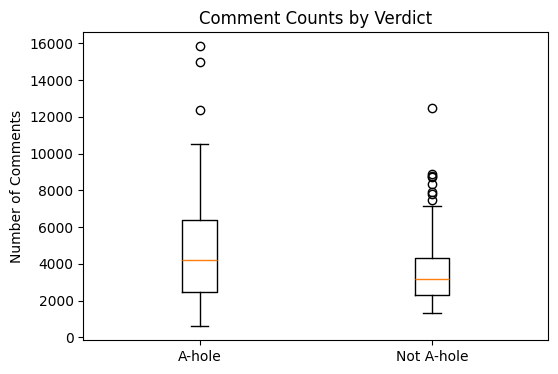

In [20]:
import matplotlib.pyplot as plt

data = [df_a_hole.num_comments, df_not_a_hole.num_comments]
labels = ['A-hole', 'Not A-hole']

plt.figure(figsize=(6,4))
plt.boxplot(data, tick_labels = labels)
plt.ylabel('Number of Comments')
plt.title('Comment Counts by Verdict')
plt.show()


### Concatenating the two dataframes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Concatenate the two DataFrames
df = pd.concat([df_a_hole, df_not_a_hole], ignore_index=True)

# 2. Make sure created_time is datetime, then pull out the year
df['created_time'] = pd.to_datetime(df['created_time'])
df['year'] = df['created_time'].dt.year

# df.to_csv('top450-aita-balanced.csv', index=False)

## Brief Dataset Visualization

In [10]:
df = pd.read_csv("top450-aita-balanced.csv")

In [11]:
df["link_flair_text"].value_counts()

link_flair_text
Asshole           225
Not the A-hole    225
Name: count, dtype: int64

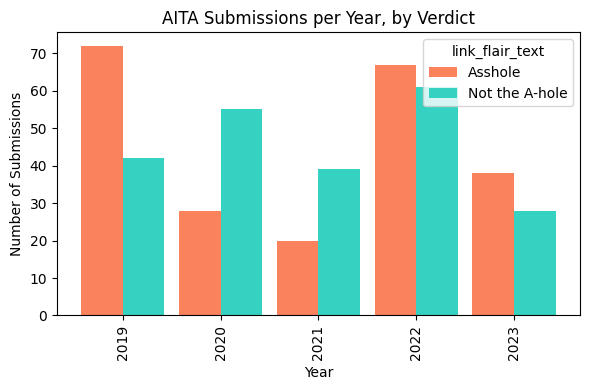

In [22]:
# keep the grouping code exactly as before …
year_flair_counts = (
    df.groupby(['year', 'link_flair_text'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# make sure the columns are in the order you want
year_flair_counts = year_flair_counts[['Asshole', 'Not the A-hole']]

ax = year_flair_counts.plot(
    kind='bar',
    figsize=(6, 4),
    color=["#fa825d", "#35d2c2"],   # ← force blue & orange
    width=0.85
)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Submissions')
ax.set_title('AITA Submissions per Year, by Verdict')
ax.legend(title='link_flair_text')
plt.tight_layout()
plt.show()


# Comments Dataset

In [38]:
df = pd.read_csv("top450-aita-balanced.csv")

In [39]:
submissions_id = df["id"]
submissions_id

0       achoyx
1       ak0zkc
2       asprlr
3       au9bkj
4       awtof3
        ...   
445    15c8d0a
446    15hbw8d
447    15kcdv7
448    16r0ybi
449    175ddnr
Name: id, Length: 450, dtype: object

## Gathering Data

In [40]:
import time
import pandas as pd
import praw
from datetime import datetime, timezone


def _safe_author_name(author):
    return getattr(author, "name", None) if author else None


def collect_reddit_data(
    submission_ids,
    reddit,
    verbose=True,
    top_limit=15,
    second_limit=5,
    third_limit=3,
    replace_more_limit=None,
):
    submission_ids = list(submission_ids)
    total = len(submission_ids)
    start = time.time()
    rows = []
    for idx, sid in enumerate(submission_ids, 1):
        if verbose:
            elapsed = time.time() - start
            avg = elapsed / idx
            eta = avg * (total - idx)
            print(f"[{idx}/{total}] id={sid} elapsed={elapsed:.1f}s eta={eta:.1f}s")

        sub = reddit.submission(id=sid)
        sub.comments.replace_more(limit=replace_more_limit)

        l1_ids, l1_auth, l1_body = [], [], []
        l2_ids, l2_auth, l2_body = [], [], []
        l3_ids, l3_auth, l3_body = [], [], []

        for c1_idx, c1 in enumerate(sub.comments):
            if top_limit is not None and c1_idx >= top_limit:
                break
            l1_ids.append(c1.id)
            l1_auth.append(_safe_author_name(c1.author))
            l1_body.append(c1.body)
            for c2_idx, c2 in enumerate(c1.replies):
                if second_limit is not None and c2_idx >= second_limit:
                    break
                l2_ids.append(c2.id)
                l2_auth.append(_safe_author_name(c2.author))
                l2_body.append(c2.body)
                for c3_idx, c3 in enumerate(c2.replies):
                    if third_limit is not None and c3_idx >= third_limit:
                        break
                    l3_ids.append(c3.id)
                    l3_auth.append(_safe_author_name(c3.author))
                    l3_body.append(c3.body)

        row = {
            "submission_id": sid,
            "author": _safe_author_name(sub.author),
            "flair": sub.link_flair_text,
            "link": f"https://www.reddit.com{sub.permalink}",
            "created_utc": sub.created_utc,
            "created_time": datetime.fromtimestamp(sub.created_utc, timezone.utc),
            "selftext": f"{sub.title}\n\n{sub.selftext}",
            "level1_ids": l1_ids,
            "level1_authors": l1_auth,
            "level1_bodies": l1_body,
            "level1_count": len(l1_ids),
            "level2_ids": l2_ids,
            "level2_authors": l2_auth,
            "level2_bodies": l2_body,
            "level2_count": len(l2_ids),
            "level3_ids": l3_ids,
            "level3_authors": l3_auth,
            "level3_bodies": l3_body,
            "level3_count": len(l3_ids),
        }

        rows.append(row)
    return pd.DataFrame(rows)


In [41]:
comments_df = collect_reddit_data(submissions_id,
                                  reddit,
                                  verbose = True,
                                  top_limit = 50,
                                  second_limit = 20,
                                  third_limit = 10,
                                  replace_more_limit = 0)

[1/450] id=achoyx elapsed=0.0s eta=0.0s
[2/450] id=ak0zkc elapsed=4.0s eta=896.2s
[3/450] id=asprlr elapsed=7.5s eta=1116.1s
[4/450] id=au9bkj elapsed=10.9s eta=1219.9s
[5/450] id=awtof3 elapsed=14.7s eta=1308.0s
[6/450] id=azofrl elapsed=18.5s eta=1369.2s
[7/450] id=b0xd7g elapsed=22.2s eta=1403.4s
[8/450] id=b12st4 elapsed=26.1s eta=1444.7s
[9/450] id=b6wg38 elapsed=29.7s eta=1455.5s
[10/450] id=b9a3mo elapsed=33.2s eta=1460.6s
[11/450] id=birkjn elapsed=36.4s eta=1451.6s
[12/450] id=bk763q elapsed=41.8s eta=1527.2s
[13/450] id=blpyy3 elapsed=46.2s eta=1554.1s
[14/450] id=bt0m1g elapsed=49.4s eta=1539.5s
[15/450] id=bu4ugr elapsed=52.2s eta=1515.0s
[16/450] id=buiasv elapsed=56.0s eta=1517.7s
[17/450] id=bvxqh8 elapsed=59.9s eta=1525.5s
[18/450] id=bw93wg elapsed=63.2s eta=1517.8s
[19/450] id=bxk596 elapsed=67.1s eta=1521.5s
[20/450] id=c0i3oz elapsed=70.4s eta=1513.7s
[21/450] id=c1nkh3 elapsed=73.8s eta=1507.7s
[22/450] id=c1vwd3 elapsed=77.0s eta=1497.6s
[23/450] id=c45x4l elapsed

In [ ]:
# comments_df.to_csv('top450-aita-balanced-comments.csv', index=False)

## Visualizing Comment Counts

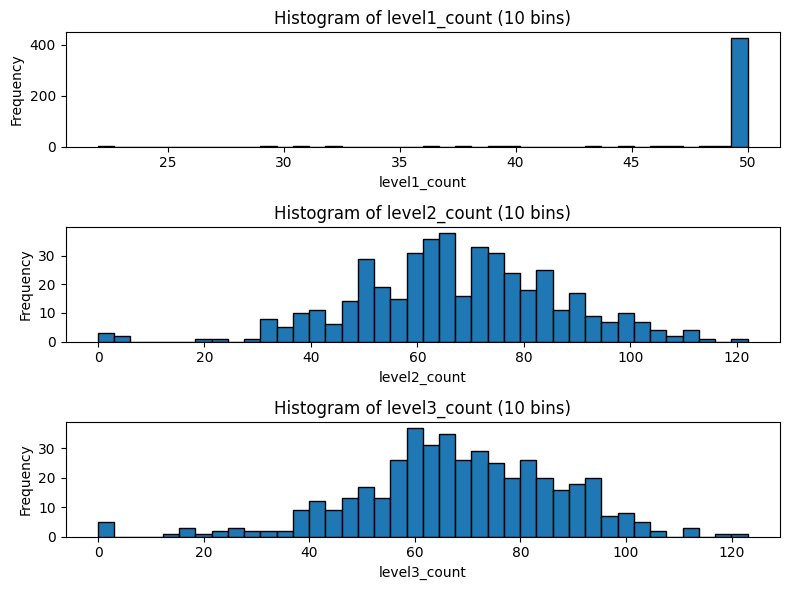

In [ ]:
data1 = comments_df["level1_count"].astype(int)
data2 = comments_df["level2_count"].astype(int)
data3 = comments_df["level3_count"].astype(int)

# Create 3 vertical subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

n_bins = 40

# Plot with fixed 10 bins each
axes[0].hist(data1, bins=n_bins, edgecolor="black", align="mid")
axes[0].set_title("Histogram of level1_count (10 bins)")
axes[0].set_xlabel("level1_count")
axes[0].set_ylabel("Frequency")

axes[1].hist(data2, bins=n_bins, edgecolor="black", align="mid")
axes[1].set_title("Histogram of level2_count (10 bins)")
axes[1].set_xlabel("level2_count")
axes[1].set_ylabel("Frequency")

axes[2].hist(data3, bins=n_bins, edgecolor="black", align="mid")
axes[2].set_title("Histogram of level3_count (10 bins)")
axes[2].set_xlabel("level3_count")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [69]:
comments_df.head()

,submission_id,author,flair,link,created_utc,created_time,selftext,level1_ids,level1_authors,level1_bodies,level1_count,level2_ids,level2_authors,level2_bodies,level2_count,level3_ids,level3_authors,level3_bodies,level3_count
0,achoyx,GirlFriendRestaurant,Asshole,https://www.reddit.com/r/AmItheAsshole/comment...,1.546605e+09,2019-01-04 12:25:56+00:00,AITA for very rarely/almost never wanting to g...,"[ed84khb, ed8cpmw, ed81844, ed7yfx1, ed7ysdq, ...","[Angrychristmassgnome, None, andreaalma15, llo...","[As a chef: yes, YTA.\n\nYou’re expecting her ...",50,"[ed8gfx5, ed85cby, ed8w37z, ed93ray, eda5fkm, ...","[Angrychristmassgnome, AnimatronicAardvark, No...","[Oh, and since being considerate appears to be...",100,"[ed8n5qe, ed9kqqa, edaxam6, ed9h5by, ed8nji0, ...","[danger_o_day, akamj7, Angrychristmassgnome, a...","[If you can't empathize yourself, store-bought...",65
1,ak0zkc,BreadBreaker09,Asshole,https://www.reddit.com/r/AmItheAsshole/comment...,1.548511e+09,2019-01-26 13:50:42+00:00,AITA for telling my waitress's manager she did...,"[ef163hs, ef15qmf, ef11mv7, ef1gbxo, ef0hzqt, ...","[Spambop, Balenciallahh, LuxNocte, sleepyplati...",[lmao /u/BreadBreaker09 bet you didn't think y...,50,"[ef285wl, ef2zhai, ef1ojfk, ef2vse4, ef1f993, ...","[_banana_phone, QUAN-FUSION, None, None, SaveT...",[He needs to leave a tip for this roast! \n\nB...,102,"[ef1r8xl, ef1u2ez, ef1whjl, ef103e8, ef190f7, ...","[nick82614, 4ev_uh, G-BreadMan, its_the_squirr...","[My thoughts too, plus getting in good with co...",89
2,asprlr,KittenBox8,Asshole,https://www.reddit.com/r/AmItheAsshole/comment...,1.550677e+09,2019-02-20 15:42:14+00:00,AITA for not letting my kids go on vacation wi...,"[egvujo2, egvtffm, egvt6bn, egw44bl, egvt7ue, ...","[None, Swiollvfer, None, theuserie, Mac4491, N...","[[deleted], YTA.\n\n> my ex told them I was no...",50,"[egwmdjg, egwt1ip, egwpt5p, egwpvby, egwtm63, ...","[sprizzle06, EowynLOTR, PM_ME_YOUR_REPO, None,...","[Can confirm, I no longer speak to my mother b...",99,"[egwtha9, egwulom, egwur53, egwwyi9, egwqm98, ...","[GiantPurplePeopleEat, IAmAssButtKingofHell, S...",[Same thing with my dad and I've completely cu...,76
3,au9bkj,BigBawluh,Asshole,https://www.reddit.com/r/AmItheAsshole/comment...,1.551024e+09,2019-02-24 16:07:56+00:00,AITA for making an obese man pay me cash to ta...,"[eh7csap, eh6uxit, eh7ef30, eh6okk3, eh6i89w, ...","[None, SnausageFest, peterjmonday, tackymanner...",[now this is the quality posts we should upvot...,50,"[eh76um8, eh74mg9, eh771ce, eh72eo8, eh7gmlr, ...","[Deathwatch72, MiloReynolds, Centerpoint360, N...",[Can we have a bot that tallies the responses ...,102,"[eh77sxh, eh79uh9, eh79uo6, eh75cpp, eh7thgx, ...","[None, TheOutrageousClaire, SnausageFest, _may...","[[removed], [This question is answered in our ...",57
4,awtof3,throwaway52817276,Asshole,https://www.reddit.com/r/AmItheAsshole/comment...,1.551617e+09,2019-03-03 12:44:56+00:00,AITA for kicking my sister out of my wedding d...,"[ehp5dod, ehp2qyy, ehp8fmh, ehpa7vh, ehp2ao8, ...","[AltoAJ, None, KRS-wine, None, kashikoicat, No...",[YTA\n\nEveryone here has already stated good ...,50,"[ehpgdmd, ehpheta, ehpkxjo, ehptc86, ehpq72h, ...","[None, hc600, Thenoblehigh, happythoughts413, ...",[THIS! The sister was making a point that the ...,73,"[ehpucrs, ehpb1rq, ehpnefh, ehpgm4p, ehpgegu, ...","[BasicDesignAdvice, clocksailor, beanicus, Reg...","[>Nobody was paying attention to me, at my own...",73
